Loaded 169 SiPM hits
Time range: 1.69 to 131.78 ns
Spatial ranges: X: -199.98 to 199.49 mm
Spatial ranges: Y: -199.60 to 199.69 mm
Spatial ranges: Z: 0.53 to 37.07 mm
              SipmName  Time(ns)    X(mm)     Y(mm)      Z(mm)  Energy(eV)  \
0    SiPM_Bottom_0_0_0   1.94632 -155.604 -198.9340   0.530000     2.48802   
1    SiPM_Bottom_0_0_0   2.70458 -155.384 -197.2860   0.530000     2.36612   
2    SiPM_Bottom_0_0_0   2.99813 -155.599 -197.4710   0.530000     2.46084   
3    SiPM_Bottom_0_0_0   3.50216 -155.539 -198.6230   0.530000     2.38640   
4    SiPM_Bottom_0_0_0   6.12683 -156.064 -199.5980   0.578803     2.59987   
..                 ...       ...      ...       ...        ...         ...   
164     SiPM_Top_3_4_0  25.53560 -197.542   44.4135  35.630000     2.43207   
165     SiPM_Top_3_4_0  63.84250 -198.538   45.0006  35.630000     2.45043   
166     SiPM_Top_3_5_0  23.56950 -197.846   81.1192  37.070000     2.49436   
167     SiPM_Top_3_6_0  10.53820 -199.729  118.5300  

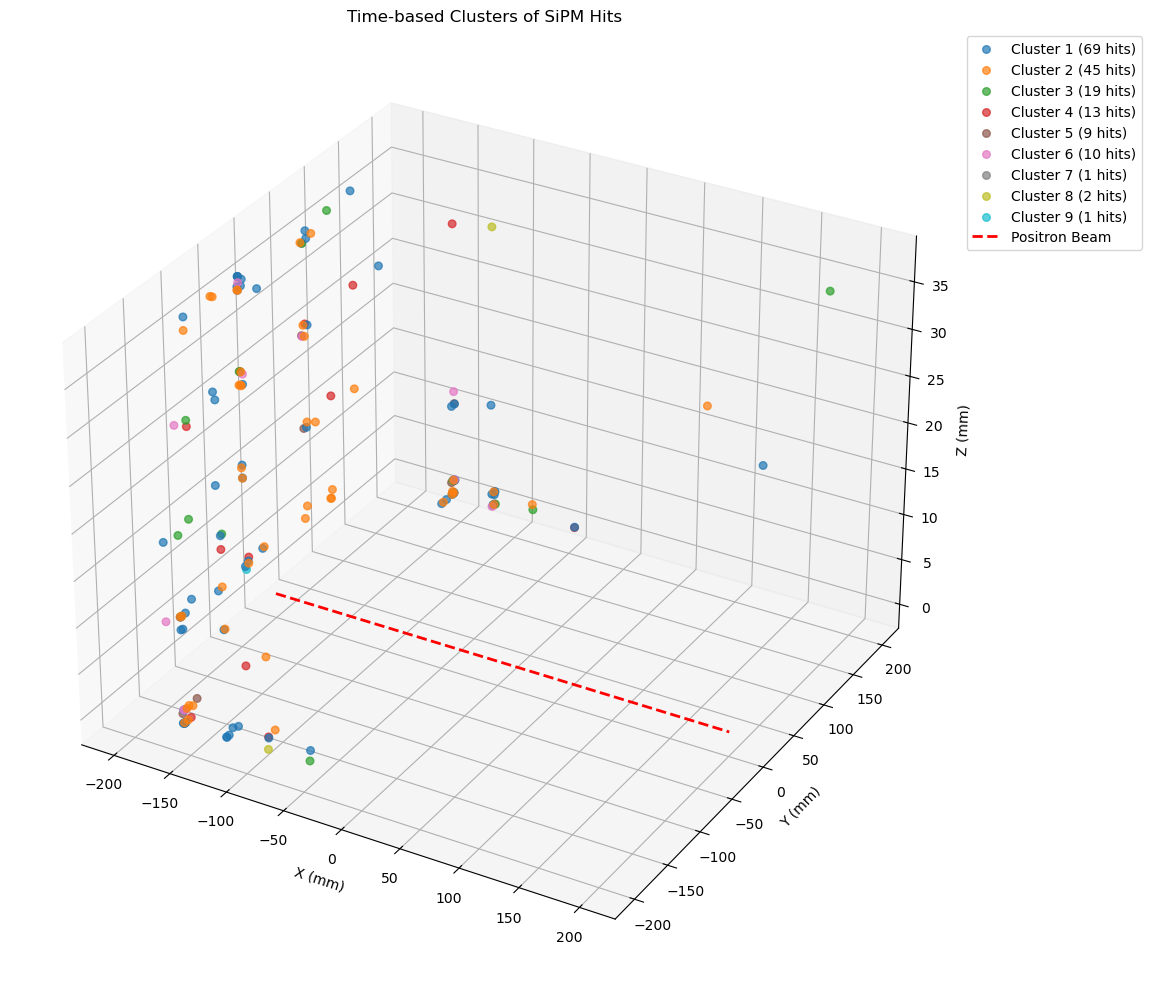

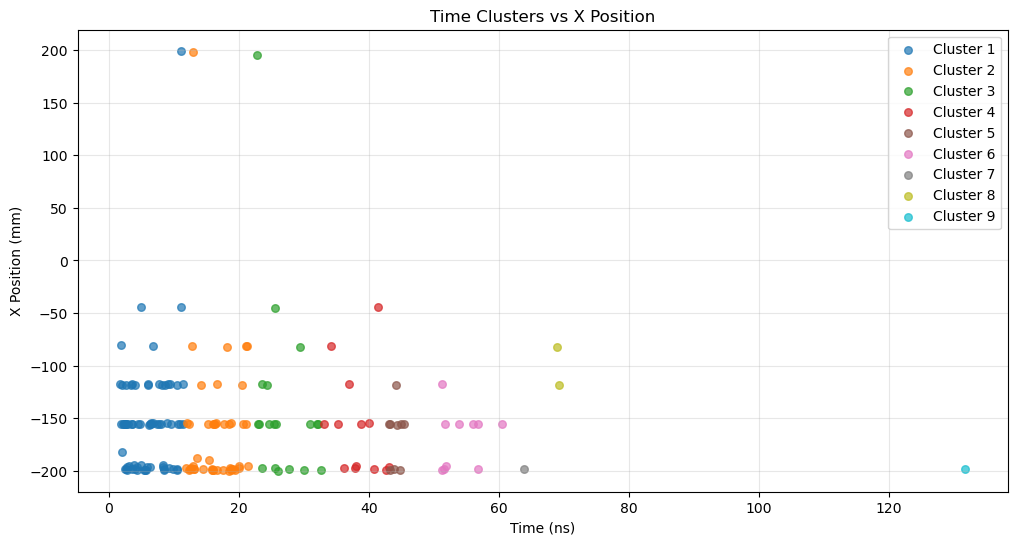

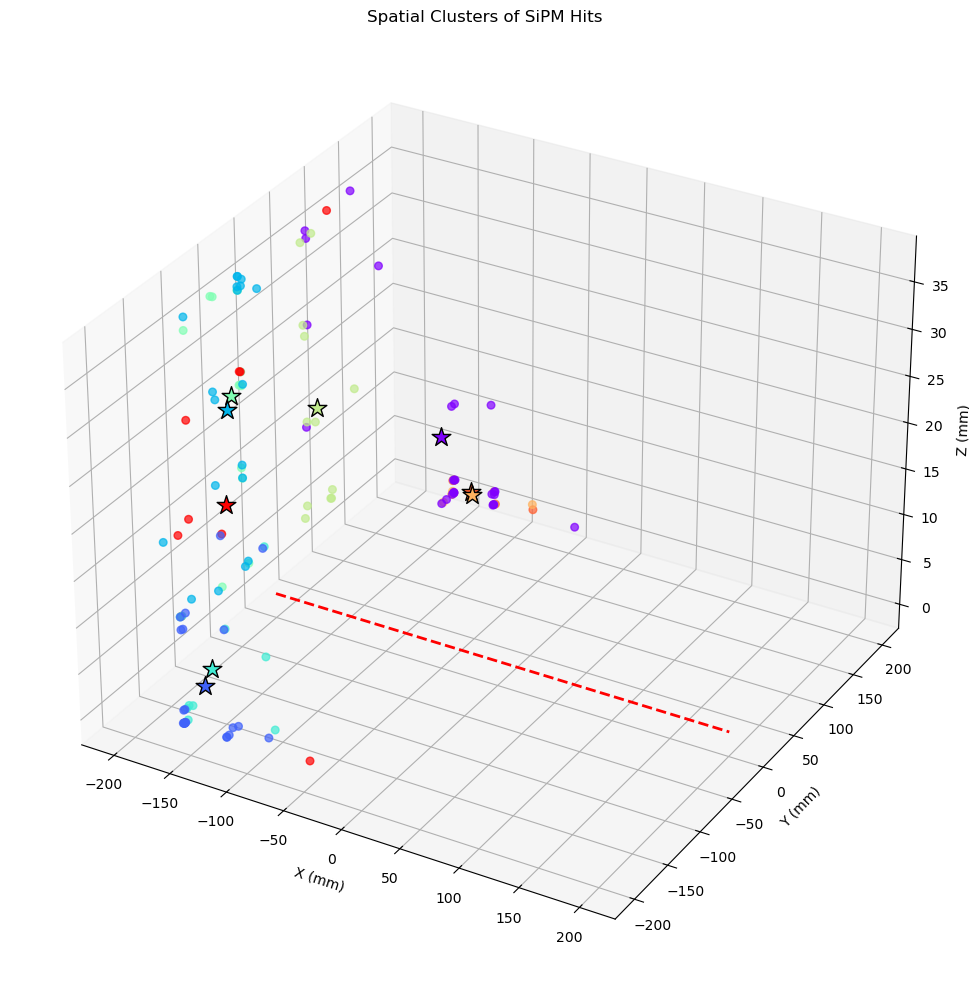

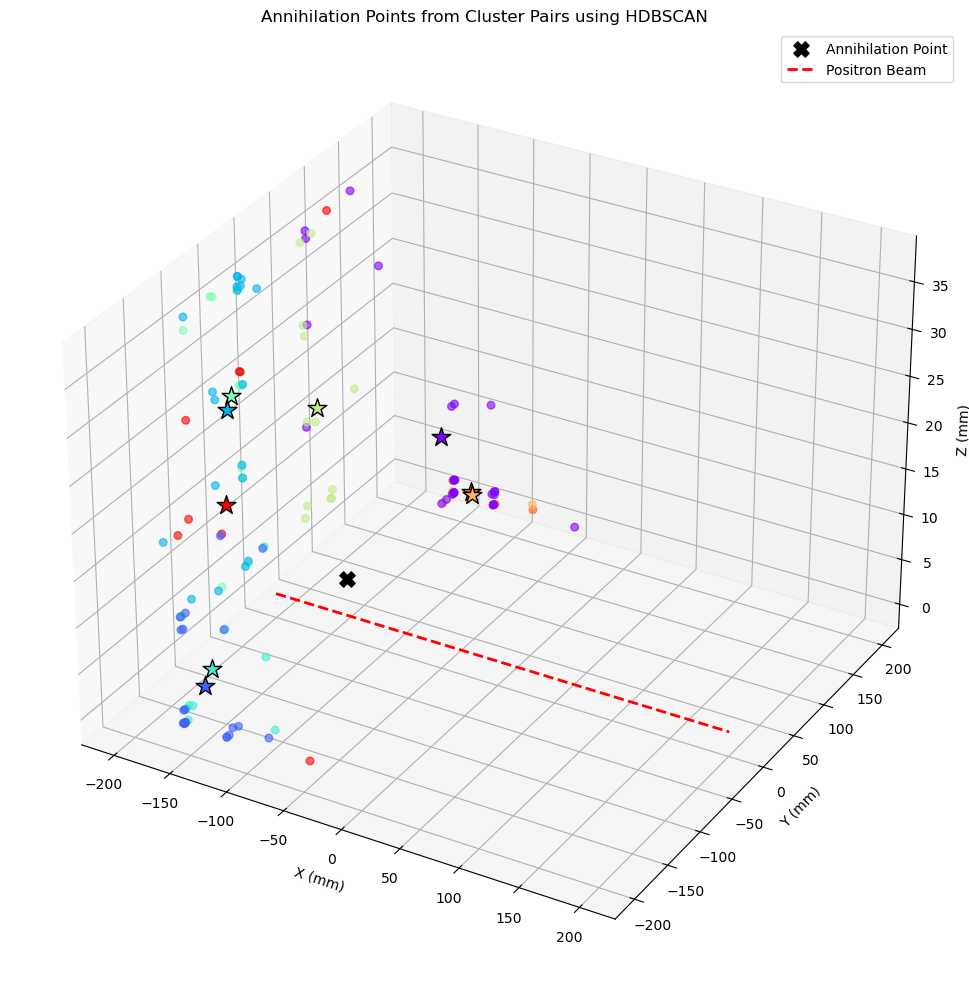

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import HDBSCAN
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from itertools import combinations
import math
import ast

def load_sipm_data(csv_file_path):
    
    sipm_df = pd.read_csv(csv_file_path)
    print(f"Loaded {len(sipm_df)} SiPM hits")
    print(f"Time range: {sipm_df['Time(ns)'].min():.2f} to {sipm_df['Time(ns)'].max():.2f} ns")
    print(f"Spatial ranges: X: {sipm_df['X(mm)'].min():.2f} to {sipm_df['X(mm)'].max():.2f} mm")
    print(f"Spatial ranges: Y: {sipm_df['Y(mm)'].min():.2f} to {sipm_df['Y(mm)'].max():.2f} mm")
    print(f"Spatial ranges: Z: {sipm_df['Z(mm)'].min():.2f} to {sipm_df['Z(mm)'].max():.2f} mm")
    print(sipm_df)
    return sipm_df


def preprocess_sipm_data(sipm_df):
    
    sipm_df = sipm_df.sort_values(by='Time(ns)')
    # create a clean working copy with renamed columns
    processed_df = sipm_df.copy()
    processed_df = processed_df.rename(columns={
        'Time(ns)': 'time',
        'X(mm)': 'x',
        'Y(mm)': 'y', 
        'Z(mm)': 'z',
        'Energy(eV)': 'energy',
        'Wavelength(nm)': 'wavelength'
    })
    processed_df['hit_id'] = np.arange(len(processed_df))
    #print("final process_df:", processed_df)
    return processed_df

def visualize_time_clusters(time_clusters, beam_start, beam_end):
    
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    colors = plt.cm.tab10(np.linspace(0, 1, len(time_clusters)))
    
    for i, cluster in enumerate(time_clusters):
        ax.scatter(cluster['x'], cluster['y'], cluster['z'], c=[colors[i]], label=f'Cluster {i+1} ({len(cluster)} hits)', alpha=0.7, s=30)
    
    
    ax.plot([beam_start[0], beam_end[0]], [beam_start[1], beam_end[1]], [beam_start[2], beam_end[2]], 'r--', linewidth=2, label='Positron Beam')
    ax.set_xlabel('X (mm)')
    ax.set_ylabel('Y (mm)')
    ax.set_zlabel('Z (mm)')
    ax.set_title('Time-based Clusters of SiPM Hits')
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
    
    plt.tight_layout()
    plt.savefig('time_clusters_3d.png')
    
    plt.figure(figsize=(12, 6))
    
    for i, cluster in enumerate(time_clusters):
        plt.scatter(cluster['time'], cluster['x'], c=[colors[i]], label=f'Cluster {i+1}', alpha=0.7, s=30)
    
    plt.xlabel('Time (ns)')
    plt.ylabel('X Position (mm)')
    plt.title('Time Clusters vs X Position')
    plt.grid(alpha=0.3)
    plt.legend()
    plt.savefig('time_clusters_vs_position.png')


def time_based_clustering(processed_df, max_time_gap=5, max_duration=10):
    processed_df = (processed_df
                    .sort_values('time')
                    .reset_index(drop=True))

    time_clusters = []
    first_hit = processed_df.iloc[0]
    current_cluster    = [ first_hit ]
    cluster_start_time = last_time = first_hit['time']

    for hit in processed_df.iloc[1:].itertuples():
        current_time = hit.time
        if current_time - last_time <= max_time_gap and current_time - cluster_start_time <= max_duration:
            current_cluster.append(processed_df.iloc[hit.Index])
        else:
            time_clusters.append(pd.DataFrame(current_cluster))
            new_series = processed_df.iloc[hit.Index]
            current_cluster    = [ new_series ]
            cluster_start_time = current_time

        last_time = current_time

    if current_cluster:
        time_clusters.append(pd.DataFrame(current_cluster))

    #print(f"Time‐based clustering (gap≤{max_time_gap} ns, dur≤{max_duration} ns):")
    for i, c in enumerate(time_clusters, 1):
        t0, t1 = c['time'].min(), c['time'].max()
        print(f"  Cluster {i}: {len(c)} hits, {t0:.2f}–{t1:.2f} ns")

    return time_clusters

def spatial_clustering(time_clusters, max_distance, min_samples, min_cluster_size):

    all_clusters = []
    next_id = 0

    for t_idx, df in enumerate(time_clusters):
        if len(df) < min_cluster_size:
            continue

        xyz    = df[['x','y','z']].values
        labels = HDBSCAN(min_cluster_size = min_samples, cluster_selection_epsilon=max_distance).fit_predict(xyz)
        #labels = HDBSCAN(min_cluster_size = min_samples).fit_predict(xyz)
        df = df.copy()
        df['local_label'] = labels

        local_to_global = {}
        for lbl in np.unique(labels):
            if lbl == -1:     
                continue
            local_to_global[lbl] = next_id
            next_id += 1

        df['global_label'] = [ local_to_global.get(lbl, -1) for lbl in labels ]

        for lbl, gid in local_to_global.items():
            hits = df[df['local_label'] == lbl]
            if len(hits) >= min_cluster_size:
                all_clusters.append(hits)

    return all_clusters

def visualize_spatial_clusters(spatial_clusters, beam_start, beam_end):
    
    if not spatial_clusters:
        print("No spatial clusters to visualize")
        return
        
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    colors = plt.cm.rainbow(np.linspace(0, 1, len(spatial_clusters)))
    
    for i, cluster in enumerate(spatial_clusters):
        ax.scatter(cluster['x'], cluster['y'], cluster['z'], c=[colors[i]], label=f'Cluster {i+1} ({len(cluster)} hits)', alpha=0.7, s=30)
        
        centroid = cluster[['x', 'y', 'z']].mean().values
        ax.scatter(centroid[0], centroid[1], centroid[2], c=[colors[i]], marker='*', s=200, edgecolor='black')
    
    ax.plot([beam_start[0], beam_end[0]], [beam_start[1], beam_end[1]], [beam_start[2], beam_end[2]], 'r--', linewidth=2, label='Positron Beam')
    
    ax.set_xlabel('X (mm)')
    ax.set_ylabel('Y (mm)')
    ax.set_zlabel('Z (mm)')
    ax.set_title('Spatial Clusters of SiPM Hits')
    
    plt.tight_layout()
    plt.savefig('HDBSCAN_spatial_clusters_3d.png')

def find_annihilation_candidates(centroids, centroids_mean_time, beam_start, beam_end, angle_threshold=10):
    
    beam_vec = np.array(beam_end) - np.array(beam_start)
    beam_dir = beam_vec / np.linalg.norm(beam_vec)
    print("beam_vec:", beam_vec)
    print("beam_dir:", beam_dir)
    xs = np.arange(beam_start[0], beam_end[0]+1, 1)
    angle_dict = {}
    
    for i in xs:
        angles = []
        for c in centroids:
            v = c - [i, 0, 0]
            cosθ = np.dot(v, beam_dir) / np.linalg.norm(v)
            angles.append(np.degrees(np.arccos(np.clip(cosθ, -1.0, 1.0))))
        angle_dict[f"[{i}, 0, 0]"] = angles
    
    angle_threshold = 1 

    results = []  
    candidates = []
    for beam_point, angles in angle_dict.items():
        for i, j in combinations(range(len(angles)), 2):
            if abs((angles[i] + angles[j]) - 180) <= angle_threshold:
                  c1 = centroids[i]
                  c2 = centroids[j]
                  time_diff = abs(centroids_mean_time[i] - centroids_mean_time[j])
                  midpoint = (c1 + c2) / 2
                  beam_point1 = np.array(ast.literal_eval(beam_point))
                  euc_distance = math.sqrt(((beam_point1[0]) - (midpoint[0]))**2 + ((beam_point1[1]) - (midpoint[1]))**2 
                                      + ((beam_point1[2]) - (midpoint[2]))**2)
                  if euc_distance <= 5 and time_diff <= 5:
                      if not any(r["centroid_indices"] == (i, j) for r in results):
                           candidates.append(midpoint)
                           results.append({
                               "beam_point": beam_point,
                               "centroid_indices": (i, j),
                               "midpoint": midpoint
                           })

    for r in results:
        print(f"At beam {r['beam_point']}, centroids {r['centroid_indices']} sum to 180°, midpoint = {r['midpoint']}")

    return candidates

def visualize_annihilation_points(spatial_clusters, centroids, annihilation_points, beam_start, beam_end):
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    colors = plt.cm.rainbow(np.linspace(0, 1, len(spatial_clusters)))

    for i, cluster in enumerate(spatial_clusters):
        ax.scatter(cluster['x'], cluster['y'], cluster['z'], c=[colors[i]], alpha=0.6, s=30)
        ax.scatter(*centroids[i], c=[colors[i]], marker='*', s=200, edgecolor='black')

    for point in annihilation_points:
        ax.scatter(*point, color='black', marker='X', s=120, label='Annihilation Point')

    ax.plot([beam_start[0], beam_end[0]], [beam_start[1], beam_end[1]], [beam_start[2], beam_end[2]], 'r--', linewidth=2, label='Positron Beam')


    ax.set_xlabel('X (mm)')
    ax.set_ylabel('Y (mm)')
    ax.set_zlabel('Z (mm)')
    ax.set_title('Annihilation Points from Cluster Pairs using HDBSCAN')
    ax.legend()
    plt.tight_layout()
    plt.savefig("HDBSCAN_annihilation_points_3d.png")
    plt.show()

def main_processing(csv_file_path, beam_start, beam_end, max_time_gap=5, max_distance=50, min_samples = 5, min_cluster_size=5 ):
    
    sipm_df = load_sipm_data(csv_file_path)
   
    processed_df = preprocess_sipm_data(sipm_df)
    #print("processed_df:", processed_df)
    time_clusters = time_based_clustering(processed_df, max_time_gap)
    #print("Time clusters:", time_clusters)
    
    visualize_time_clusters(time_clusters, beam_start, beam_end)
    spatial_clusters = spatial_clustering(time_clusters, max_distance, min_samples, min_cluster_size)
    print("spatial_clusters", spatial_clusters)
    visualize_spatial_clusters(spatial_clusters, beam_start, beam_end)

    centroids = np.array([cluster[['x', 'y', 'z']].mean().values for cluster in spatial_clusters])
    print("centroids: ", centroids)
    centroids_mean_time = np.array([cluster[['time']].mean().values for cluster in spatial_clusters])
    print("centroids_mean_time:", centroids_mean_time)
    annihilation_points1 = find_annihilation_candidates(centroids, centroids_mean_time, beam_start, beam_end, angle_threshold=10)

    print("Annihilation Points:", annihilation_points1)
    visualize_annihilation_points(spatial_clusters, centroids, annihilation_points1, beam_start, beam_end)

    for i, cluster in enumerate(spatial_clusters):
        cluster.to_csv(f"HDBSCAN_spatial_cluster_{i+1}.csv", index=False)
    
    return spatial_clusters

if __name__ == "__main__":
    csv_file_path = "sipm_hits_run0.csv"
    beam_start = [-200, 0, 0]
    beam_end = [200, 0, 0]
    spatial_clusters = main_processing(
        csv_file_path, 
        beam_start,
        beam_end,
        max_time_gap=5,      # 5 ns max time gap for time clustering
        #max_time_gap=2,
        max_distance=50,     # 50 mm max distance for spatial clustering
        min_samples = 5,
        min_cluster_size=5   # Minimum 5 hits to form a significant cluster
        
    )